## Background
This Project focuses on building an RNN model to predict the next character in a sequence of text data from Shakespeare's plays.

## 1.1 - Data Preprocessing

In [ ]:
import numpy as np
! pip install unidecode
import unidecode
import string
import time
import torch
import pdb

import torch.nn as nn
from torch.autograd import Variable

all_characters = string.printable
print(all_characters)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.8 MB/s eta 0:00:00
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



This section is to load the text given in the google drive directory. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file

file_path = '/shakespeare.txt'
file = read_file(file_path)
file_len = len(file)
print(f"file length: {file_len}")
print(file[:100])

file length: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


## 1.2 Function to generate random chunk of data from given dataset

In [ ]:
def get_random_chunk(file, rng, chunk_len = 100):
    start_index = rng.randint(0, len(file) - chunk_len)
    end_index = start_index + chunk_len + 1
    chunk = file[start_index:end_index]
    return chunk[:-1], chunk[1:]

rng = np.random.RandomState(123)
curr_chunk, next_chunk = get_random_chunk(file='Hello world!', rng=rng, chunk_len=10)
print(f"curr_chunk =>{curr_chunk}\n next_chunk=> {next_chunk}")

print(f"Is curr_chunk and next_chunk same length: {len(curr_chunk) == len(next_chunk)}")
print(f"Is next chunk shifted by one: {curr_chunk[1:] == next_chunk[:-1]}")


curr_chunk =>Hello worl
 next_chunk=> ello world
Is curr_chunk and next_chunk same length: True
Is next chunk shifted by one: True


## 1.3 - Implement function to convert to tensors

In [ ]:
def to_tensor(string):
    tensor = torch.zeros(len(string), 1, len(all_characters))
    for i, char in enumerate(string):
      tensor[i][0][all_characters.index(char)] = 1
    return tensor

def get_one_hot_tensors(input, output):
    return to_tensor(input), to_tensor(output)

rng = np.random.RandomState(123)
input, output = get_random_chunk(file, rng,  50)
print(input.replace('\n', ' '))
print(output.replace('\n', ' '))
input_tensor, output_tensor = get_one_hot_tensors(input, output)
print(f"input shape: {input_tensor.shape}")
print(f"output shape: {output_tensor.shape}")

g's, which Florizel I now name to you; and with sp
's, which Florizel I now name to you; and with spe
input shape: torch.Size([50, 1, 100])
output shape: torch.Size([50, 1, 100])


## 2.1 - Build RNN model

RNN model is built using PyTorch
- nn.GRU is used to implement the GRU algorithm for processing sequential input data.
- The decoder layer is a fully connected neural network layer that maps the output of the GRU layer to the desired output size.
- We are only implementing a single layer RNN so the model is not powerful enough to learn long-term dependencies in the text data.

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.rnn_cell = nn.GRU(input_size, hidden_size, n_layers) # set rnn_cell to nn.GRU
        self.decoder = nn.Linear(hidden_size, output_size) # decode layer

    def forward(self, input, hidden):
        # reshapes inputs to GRU and decoder layers
        input = input.view(1, 1, -1)
        output, hidden = self.rnn_cell(input, hidden)
        output = output.view(1, -1)
        output = self.decoder(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
def train(inp, target, decoder):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    input_tensor, target_tensor = get_one_hot_tensors(inp, target)
    for c in range(len(inp)):
        output, hidden = decoder(input_tensor[c], hidden)
        loss += criterion(output, torch.argmax(target_tensor[c]).unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()
    return loss.item() / max_length

In [ ]:
def evaluate(decoder, prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = to_tensor(prime_str)
    predicted = prime_str
    for p in range(len(prime_str) - 1):
        out, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = to_tensor(predicted_char)

    return predicted

[(100 5.0%) 2.7158718872070313]
Whatnirgy minpmous sorwy surs pol the that daveri
b tilg nlros be thansenort yd s tors.
enth, hin assr 

[(200 10.0%) 2.3934144592285156]
Whe and anl pay wind wa avr
Goed teag ond, tout ang witor,
I an yurl an ati slanl hinn on thes anmle w 

[(300 15.0%) 2.6698178100585936]
Whey inou, ar:
Math thim thed insspur.
On the sto: shebll hangsins him he shersty,
The s art le me sea 

[(400 20.0%) 2.340398406982422]
Whor to cutke thy tis me;
I seor, shy's at manture owe

LARDIVT:
Busterile, ing sofare, anding sofo hi 

[(500 25.0%) 2.135816802978516]
Whave groull chell watll womd!
Whas in wrest his af me the vatt cord ond forgler
By not ot mer promy m 

[(600 30.0%) 2.114157257080078]
Whe cound but sut I the the hid thace Andee fore wime she tie
I the the tach sut a corqust gout ingat  

[(700 35.0%) 2.156568756103516]
Whe cofest with in ome tole.

BARIZALUS:
AN wirr kis it And now hathin ais it or wone.

LARIE:
O, you  

[(800 40.0%) 1.9574339294433594]
Whall 

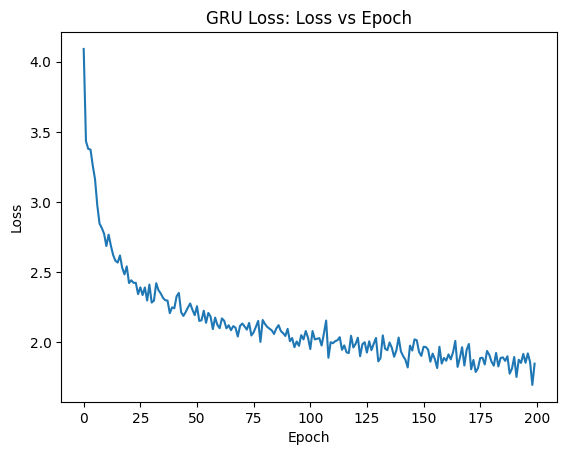

In [ ]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
max_length = len(all_characters)

decoder = RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
rng = np.random.RandomState(123)

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file, rng), decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.title("GRU Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 3.1 - Implement an LSTM model

The code below will use this instead of the GRU cell module and train the model.

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hidden=None):
        # Unpack hidden state and cell state
        hx, cx = hidden
        # Apply linear layers to input and hidden state
        linear = self.xh(input) + self.hh(hx)
        # Get outputs of applying a linear transform for each part of the LSTM
        input_linear, forget_linear, cell_linear, output_linear = linear.reshape(-1).chunk(4)
        # apply activation function, get new cell states and hidden states
        input_gate = torch.sigmoid(input_linear)
        forget_gate = torch.sigmoid(forget_linear)
        cell_gate = torch.tanh(cell_linear)
        output_gate = torch.sigmoid(output_linear)

        c_new = (forget_gate * cx) + (input_gate * cell_gate)
        h_new = output_gate * torch.tanh(c_new)

        # Pack cell state $C_t$ and hidden state $h_t$ into a single hidden state tuple
        output = h_new # For LSTM the output is just the hidden state
        hidden = (h_new, c_new) # Packed h and C
        return output, hidden



[(100 5.0%) 3.1655123901367186]
Whmo9e!ln  smeinrl u
r      eTbas ot eCle   do
o y   dveu h tn eAas o  lrlM T-,e s
go    or eaehhs weI 

[(200 10.0%) 3.080840759277344]
Whgosthmnr vouo   nie eiatry i lel  t
yecmv eIe Te ter ee! ,eofn airrgeuoseo d!nnadfnedtn clo  ten a i 

[(300 15.0%) 3.39466552734375]
WhJ;'neo trg emid c ien hurinenalthTH ;id shuntewbtn hou yedr 
hi  crn aay akehT'mon nfhn rceoi fareh  

[(400 20.0%) 3.202256774902344]
Whh Soac.Ton Ae n rar ttuatte oer ro la hin cNiainp chen k the ee
lr tho ber s to col e 
ur sulS ohar  

[(500 25.0%) 2.7829360961914062]
When thecek, thed s ase l ave ms tne d fo'or goh ghew nopre lm tah sebaled ariontd !yitergnsf tot poat 

[(600 30.0%) 2.6440185546875]
Whasos thP atos


SC
oE anoa heptthutty nor sa oit dor shavf to bits eopla-sa ul ite
 tan oud tolm sau 

[(700 35.0%) 2.722579040527344]
When thoun giind soun lom, were't lored shont t teirl seaai poid

s;

KFA OoI th tad aus andfdC Gof na 

[(800 40.0%) 2.494927978515625]
Whe doot ou

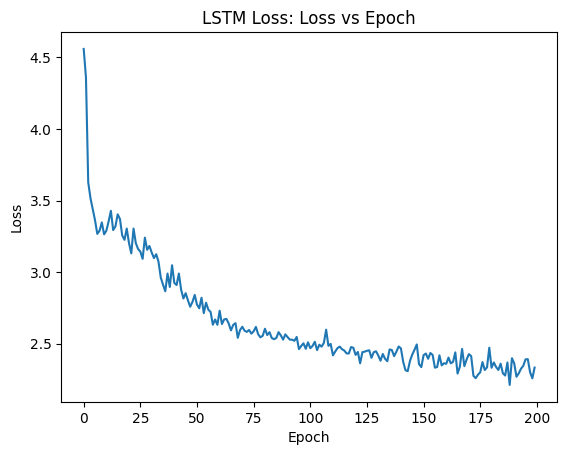

In [ ]:
lr = 0.001
class LSTM_RNN(RNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Replace the gru cell with LSTM cell
        self.rnn_cell = LSTMCell(max_length, hidden_size, max_length)

    def init_hidden(self):
        # LSTM cells need two hidden variables in a tuple of (h_t,C_t)
        return (Variable(torch.zeros(1, 1, self.hidden_size)), Variable(torch.zeros(1, 1, self.hidden_size)))

decoder = LSTM_RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

all_losses = []
loss_avg = 0
rng = np.random.RandomState(123)

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file, rng),decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

plt.plot(all_losses)
plt.title("LSTM Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# 4.1 - Implement GRU

In [ ]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.h2z = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2r = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2h = nn.Linear(input_size + hidden_size, hidden_size)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       h_t, h_t: h_t is of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
        # Concatenate hidden and input to get h_prime (see torch.cat)
        h_prime = torch.cat((hx, input), 2)
        # Use self.h2z to calculate z_t
        z_t = torch.sigmoid(self.h2z(h_prime))
        # Use self.h2r to calculate r_t
        r_t = torch.sigmoid(self.h2r(h_prime))
        # Use Hadamard product of r_t and hx and concatenate with input, Then use h2h to calculate new hidden information h_tbar
        h_tbar = torch.tanh(self.h2h(torch.cat((r_t * hx, input), 2)))
        # Update h_t with z_t, hx, and h_tbar
        h_t = (1 - z_t) * hx + z_t * h_tbar
        # Reshape h_t match input size
        h_t = h_t.reshape(1, 1, -1)
        
        return h_t, h_t   # Output and hidden are both h_t

[(100 5.0%) 2.7918072509765626]
Wh-siwn limin 
in
, toas yav gislatba-heirs oons alos nouha ee nouYlreswo hid theve't nlr hacd cat e r 

[(200 10.0%) 2.410317840576172]
Whese.

Sy any he iner,
Wore pou thur wous eoc mame and bll af wille te hatr or heallre win ill
N'd wo 

[(300 15.0%) 2.7197885131835937]
Whanger hite.

CPERECI:
The that thet scenere,
Why sethe ont whithe sus:
Mord ther sounse in nod thean 

[(400 20.0%) 2.413846740722656]
Why mungture chas thet meres lick an ice.

IUG:
Lowe and at coing gour she, ant an, sheili dort lowe f 

[(500 25.0%) 2.1850379943847655]
Whard I in the thal wtren and that, me than thil dor his ap gelcerst on the the fold thy you grets
RUS 

[(600 30.0%) 2.0726190185546876]
Who due thas, ald the hay made;
Ah't rute the hat thy sely the momco, save domy
Ard the the thy you al 

[(700 35.0%) 2.1876202392578126]
Wh wers of on sfee hom ald ar I mald undy rmander thou so mall gooplith
lod the wat sor you me ou hes  

[(800 40.0%) 1.9756118774414062]
Whis

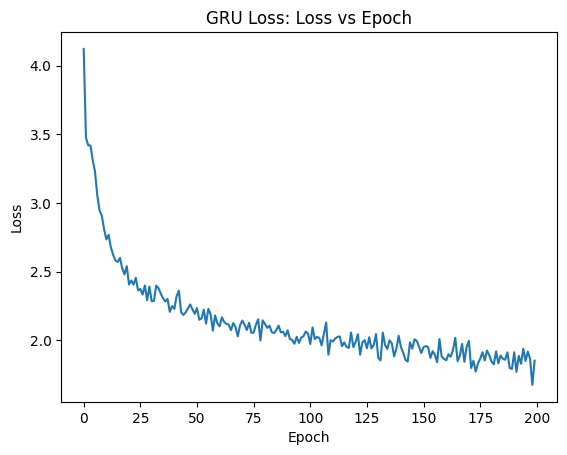

In [ ]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
max_length = len(all_characters)

# Replace the RNN module with implemented GRUcell
class GRU_RNN(RNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rnn_cell = GRUCell(max_length, hidden_size, max_length)


decoder = GRU_RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

all_losses = []
loss_avg = 0
rng = np.random.RandomState(123)

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file, rng),decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

plt.plot(all_losses)
plt.title("GRU Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()